## 18.1 작업 환경 준비
- 프로젝트 시작
- yarn add redux react-redux redux-actions
- counter 리덕스 모듈 작성
    - 모듈이란 Ducks 패턴을 사용해 액션 타입, 액션 생성 함수, 리듀서를 작성한 코드
        ```js
        import { createAction, handleActions } from "redux-actions";

        // 액션타입 정의
        const INCREASE = "counter/INCREASE";
        const DECREASE = "counter/DECREASE";

        // 액션 생성 함수
        export const increase = createAction(INCREASE);
        export const decrease = createAction(DECREASE);

        // 초기화, 상태는 꼭 객체일 필요가 없다. 숫자도 작동한다.
        const initialState = 0; 

        // 리듀서 생성, 리듀서는 변화를 일으키는 함수
        const counter = handleActions(
            {
                [INCREASE]: (state) => state + 1,
                [DECREASE]: (state) => state - 1,
            },
            initialState
        );

        export default counter;
        ```
- 루트 리듀서 생성
    - 여러 개의 리듀서를 하나로 합친 것
        ```js
        import { combineReducers } from "redux";
        import counter from "./counter";

        const rootReducer = combineReducers({
            counter,
        });

        export default rootReducer;
        ```
- 스토어 생성 후 Provider 컴포넌트를 사용해 프로젝트에 리덕스 적용
    - Provider는 리액트 컴포넌트에서 스토어를 사용할 수 있도록 해주는 컴포넌트
    - App 컴포넌트를 Provider 컴포넌트로 감싸면됨
        ```js
        import React from 'react';
        import ReactDOM from 'react-dom/client';
        import './index.css';
        import App from './App';
        import { createStore } from "redux";
        import { Provider } from "react-redux";
        import rootReducer from "./modules";

        //스토어 생성
        const store = createStore(rootReducer);

        const root = ReactDOM.createRoot(document.getElementById('root'));
        root.render(
        //리덕스 적용
        <Provider store={store}>
            <App />
        </Provider>,
        );
        ```
- 카운터 컴포넌트 생성
    ```js
    const Counter = ({ onIncrease, onDecrease, number }) => {
        return (
            <div>
                <h1>{number}</h1>
                <button onClick={onIncrease}>+1</button>
                <button onClick={onDecrease}>-1</button>
            </div>
        );
    };

    export default Counter;
    ```
    ```js 
    // CounterContainer.js
    import { connect } from "react-redux";
    import { increase, decrease } from "../modules/counter";
    import Counter from "../components/Counter";

    const CounterContainer = ({ number, increase, decrease }) => {
        return (
            <Counter number={number} onIncrease={increase} onDecrease={decrease} />
        );
    };

    //컨테이너 컴포넌트 리덕스와 연동시키기!
    export default connect(
        (state) => ({
            number: state.counter,
        }),
        {
            increase,
            decrease,
        }
    )(CounterContainer);
    ```
- App에 적용
    ```js
    import CounterContainer from "./containers/CounterContainer";

    const App = () => {
    return (
        <div>
        <CounterContainer />
        </div>
    );
    };

    export default App;
    ```

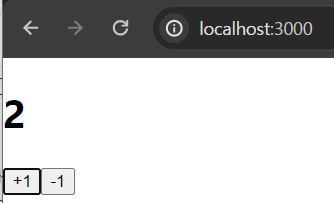

## 18.2 미들웨어란
- 액션과 리듀서 사이의 중간자
- 액션을 디스패치(액션 발생)했을 때 리듀서에서 이를 처리하기에 앞서 지정된 작업들을 실행해 주는 것
    - 전달받은 액션 콘솔에 기록, 전달받은 액션 정보를 기반으로 액션 취소, 다른 종류의 액션을 추가로 디스패치
- 실제 프로젝트 작업시 미들웨어는 직접 만들어 사용하기보단, 다른 개발자가 만들어 놓은 미들웨어를 사용하는 경우가 많다.


### 1. 미들웨어 만들기
- 액션이 디스패치 될 때마다 액션의 정보와 액션이 디스패치되기 전후의 상태를 콘솔에 보여 주는 로깅 미들웨어 만들기
```js
const loggerMiddleware = (store) => (next) => (action) => {
    //미들웨어 기본 구조
};
  
export default loggerMiddleware;
```
- store : 리덕스 스토어 인스턴스
- action : 디스패치된 액션
- next
    - 함수 형태의 파라미터 값, store.dispatch와 비슷한 역할
    - next(action)을 호출하면 그다음 처리해야 할 미들웨어에게 액션을 넘겨주고, 다음 미들웨어가 없을 때 리듀서에게 액션을 넘겨줌.
    - 미들웨어 내부에서 store.dispatch를 사용하면 첫 번째 미들웨어부터 다시 처리한다.
    - 만약 미들웨어에서 next를 사용하지 않으면 액션이 리듀서에 전달되지 않는다.
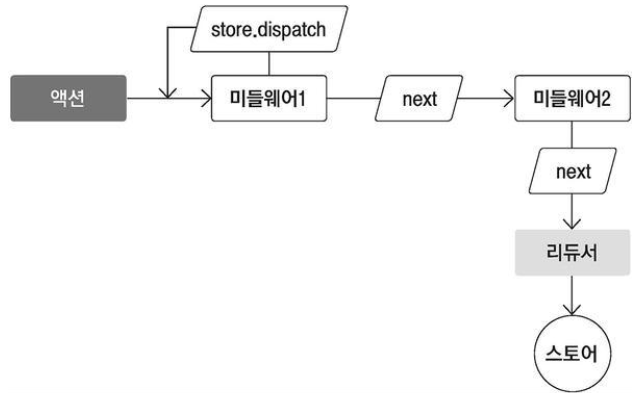

- 1 이전 상태, 2 액션 정보, 3 새로워진 상태를 순차적으로 콘솔에 보여주는 미들웨어
    ```js
    const loggerMiddleware = (store) => (next) => (action) => {
        // 액션 타입으로 log를 그룹화
        console.group(action && action.type); 
        console.log("이전 상태", store.getState());
        console.log("액션", action);
        // 다음 미들웨어 혹은 리듀서에게 전달
        next(action); 
        console.log("다음 상태", store.getState());
        //그룹 끝
        console.groupEnd(); 
    };

    export default loggerMiddleware;
    ```
-제작한 리덕스 미들웨어를 스토어에 적용하기
    - 미들웨어는 스토어를 생성하는 과정에 적용
```js
import React from "react";
import ReactDOM from "react-dom";
import "./index.css";
import App from "./App";
import { createStore, applyMiddleware } from "redux";
import rootReducer from "./modules";
import { Provider } from "react-redux";
import loggerMiddleware from "./lib/loggerMiddleware";

//스토어 생성
const store = createStore(rootReducer, applyMiddleware(loggerMiddleware));

const root = ReactDOM.createRoot(document.getElementById('root'));
root.render(
  //리덕스 적용
  <Provider store={store}>
    <App />
  </Provider>,
);
```
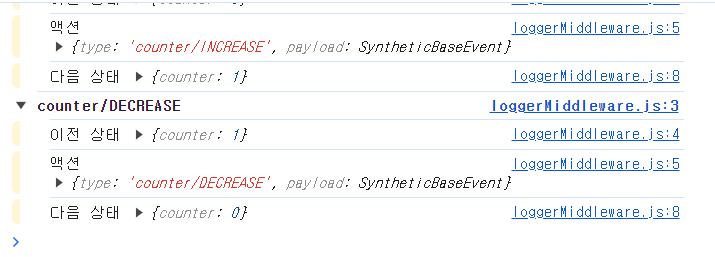

### 2. redux-logger 사용하기
- 오픈 소스 커뮤니티에 올라와 있는 redux-logger 미들웨어를 설치하고 사용
- yarn add redux-logger
    ```js
    import React from "react";
    import ReactDOM from "react-dom";
    import "./index.css";
    import App from "./App";
    import { createStore, applyMiddleware } from "redux";
    import rootReducer from "./modules";
    import { Provider } from "react-redux";
    import { createLogger } from 'redux-logger'


    const logger = createLogger()
    //스토어 생성
    const store = createStore(rootReducer, applyMiddleware(logger));

    const root = ReactDOM.createRoot(document.getElementById('root'));
    root.render(
    //리덕스 적용
    <Provider store={store}>
        <App />
    </Provider>,
    );
    ``` 

    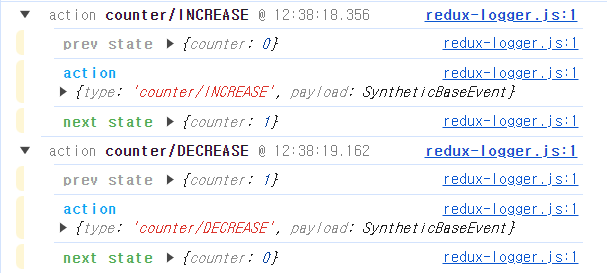
    

## 18.3 비동기 작업을 처리하는 미들웨어 사용
- redux-thunk : 비동기 작업을 처리할 때 가장 많이 사용하는 미들웨어. 함수 형태의 액션을 디스패치할 수 있게 해 준다.
- redux-saga : redux-thunk 다음으로 많이 사용되는 비동기 작업 관련 미들웨어 라이브러리. 특정 액션이 디스패치 되었을 때 정해진 로직에 따라 다른 액션을 디스패치 시키는 규칙을 작성하여 비동기 작업을 처리할 수 있게 해 준다.

### 1. redux-thunk
- Thunk란
    - 특정 작업을 나중에 할 수 있도록 미루기 위해 함수 형태로 감싼 것을 의미

- 미들웨어 적용
    - yarn add redux-thunk
    - 스토어 만들 때 적용
        ```js
        (...)
        import { thunk } from 'redux-thunk'

        //스토어 생성
        const logger = createLogger();
        const store = createStore(rootReducer, applyMiddleware(logger, thunk));

        (...)
        ```

- Thunk 생성 함수 만들기
    - redux-thunk는 액션 생성 함수에서 일반 액션 객체를 반환하는 대신 함수를 반환
    - increaseAsync와 decreaseAsync 함수를 만들어 카운터 값을 비동기적으로 변경
        ```js
        (...)
        //1초 뒤에 increase 혹은 decrease 함수를 디스패치함
        export const increaseAsync = () => (dispatch) => {
            setTimeout(() => {
                dispatch(increase());
            }, 1000);
        };
        
        export const decreaseAsync = () => (dispatch) => {
            setTimeout(() => {
                dispatch(decrease());
            }, 1000);
        };
        (...)
        ```
    - CounterContainer에서 호출하던 액션 생성 함수도 변경
        ```js
        import { connect } from "react-redux";
        import { increaseAsync, decreaseAsync } from "../modules/counter";
        import Counter from "../components/Counter";

        const CounterContainer = ({ number, increaseAsync, decreaseAsync }) => {
            return (
                <Counter
                    number={number}
                    onIncrease={increaseAsync}
                    onDecrease={decreaseAsync}
                />
            );
        };

        //컨테이너 컴포넌트 리덕스와 연동
        export default connect(
            (state) => ({
                number: state.counter,
            }),
            {
                increaseAsync,
                decreaseAsync,
            }
        )(CounterContainer);
        ```

        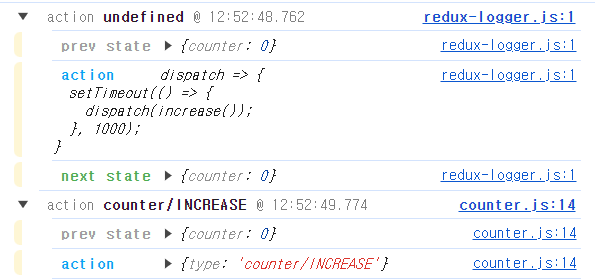

- 웹 요청 비동기 작업 처리
    - JSONPlaceholder에서 제공되는 가짜 API를 사용
    - yarn add axios
    - 사용할 API 함수화
        ```js
        import axios from "axios";

        //포스트 읽기
        export const getPost = (id) =>
            axios.get(`https://jsonplaceholder.typicode.com/posts/${id}`);

        //모든 사용자 불러오기
        export const getUsers = (id) =>
            axios.get(`https://jsonplaceholder.typicode.com/users`);
        ```
    - 리듀서 작성
        ```js
        import { handleActions } from "redux-actions";
        import * as api from "../lib/api";

        // 액션 타입을 선언
        // 한 요청당 세 개를 만듦

        const GET_POST = "sample/GET_POST";
        const GET_POST_SUCCESS = "sample/GET_POST_SUCCESS";
        const GET_POST_FAILURE = "sample/GET_POST_FAILURE";

        const GET_USERS = "sample/GET_USERS";
        const GET_USERS_SUCCESS = "sample/GET_USERS_SUCCESS";
        const GET_USERS_FAILURE = "sample/GET_USERS_FAILURE";

        // thunk 함수를 생성
        // thunk 함수 내부에서는 시작할 때, 성공했을 때, 실패했을 때 다른 액션을 디스패치

        export const getPost = (id) => async (dispatch) => {
            // 요청을 시작한 것을 알림
            dispatch({ type: GET_POST }); 
            try {
                const response = await api.getPost(id);
                dispatch({
                    type: GET_POST_SUCCESS,
                    payload: response.data,
                }); // 요청 성공
            } catch (e) {
                dispatch({
                    type: GET_POST_FAILURE,
                    payload: e,
                    error: true,
                }); // 에러 발생
                throw e; // 컴포넌트단에서 에러를 조회
            }
        };

        export const getUsers = () => async (dispatch) => {
            // 요청을 시작한 것을 알림
            dispatch({ type: GET_USERS }); 
            try {
                const response = await api.getUsers();
                dispatch({
                    type: GET_USERS_SUCCESS,
                    payload: response.data,
                }); // 요청 성공
            } catch (e) {
                dispatch({
                    type: GET_USERS_FAILURE,
                    payload: e,
                    error: true,
                }); // 에러 발생
                throw e; // 컴포넌트단에서 에러를 조회
            }
        };

        // 초기 상태를 선언
        // 요청의 로딩 중 상태는 loading이라는 객체에서 관리
        const initialState = {
            loading: {
                GET_POST: false,
                GET_USERS: false,
            },
            post: null,
            users: null,
        };

        const sample = handleActions(
            {
                [GET_POST]: (state) => ({
                    ...state,
                    loading: {
                        ...state.loading,
                        // 요청 시작
                        GET_POST: true, 
                    },
                }),
                [GET_POST_SUCCESS]: (state, action) => ({
                    ...state,
                    loading: {
                        ...state.loading,
                        // 요청 완료
                        GET_POST: false, 
                    },
                    post: action.payload,
                }),
                [GET_POST_FAILURE]: (state, action) => ({
                    ...state,
                    loading: {
                        ...state.loading,
                        // 요청 완료
                        GET_POST: false, 
                    },
                }),
                [GET_USERS]: (state) => ({
                    ...state,
                    loading: {
                        ...state.loading,
                        // 요청 시작
                        GET_USERS: true, 
                    },
                }),
                [GET_USERS_SUCCESS]: (state, action) => ({
                    ...state,
                    loading: {
                        ...state.loading,
                        // 요청 완료
                        GET_USERS: false, 
                    },
                    users: action.payload,
                }),
                [GET_USERS_FAILURE]: (state, action) => ({
                    ...state,
                    loading: {
                        ...state.loading,
                        // 요청 완료
                        GET_USERS: false, 
                    },
                }),
            },
            initialState
        );

        export default sample;
        ```
    - 루트 리듀서에 포함
        ```js
        import { combineReducers } from "redux";
        import counter from "./counter";
        import sample from "./sample";

        const rootReducer = combineReducers({
            counter,
            sample,
        });

        export default rootReducer;
        ```
    - 데이터를 렌더링 할 Sample 컴포넌트 작성 > 프레젠테이셔널 컴포넌트
        ```js
        const Sample = ({ loadingPost, loadingUsers, post, users }) => {
            return (
                <div>
                    <section>
                        <h1>포스트</h1>
                        {loadingPost && "로딩 중..."}
                        {!loadingPost && post && (// 유효성 검사 - post 데이터가 없을 때 조회하면 에러 뜨기 때문
                            <div>
                                <h3>{post.title}</h3>
                                <h3>{post.body}</h3>
                            </div>
                        )}
                    </section>
                    <hr />
                    <section>
                        <h1>사용자 목록</h1>
                        {loadingUsers && "로딩 중..."}
                        {!loadingUsers && users && (
                            <ul>
                                {users.map((user) => (
                                <li key={user.id}>
                                    {user.username}({user.email})
                                </li>
                                ))}
                            </ul>
                        )}
                    </section>
                </div>
            );
        };

        export default Sample;
        ```
    - 컨테이너 컴포넌트 작성
        ```js
        import React from "react";
        import { connect } from "react-redux";
        import Sample from "../components/Sample";
        import { getPost, getUsers } from "../modules/sample";

        const { useEffect } = React;
        const SampleContainer = ({
            getPost, getUsers, post,
            users, loadingPost, loadingUsers,
        }) => {
            //클래스 형태 컴포넌트였다면 componentDidMount
            useEffect(() => {
                getPost(1);
                getUsers(1);
            }, [getPost, getUsers]);
            return (
                <Sample
                    post={post}
                    users={users}
                    loadingPost={loadingPost}
                    loadingUsers={loadingUsers}
                />
            );
        };

        export default connect(
            ({ sample }) => ({
                post: sample.post,
                users: sample.users,
                loadingPost: sample.loading.GET_POST,
                loadingUsers: sample.loading.GET_USERS,
            }),
            {
                getPost,
                getUsers,
            }
        )(SampleContainer);
        ```
    - app 컴포넌트 적용
        ```js
        import React from "react";
        import SampleContainer from "./containers/SampleContainer";

        const App = () => {
        return (
            <div>
            <SampleContainer />
            </div>
        );
        };

        export default App;
        ```
    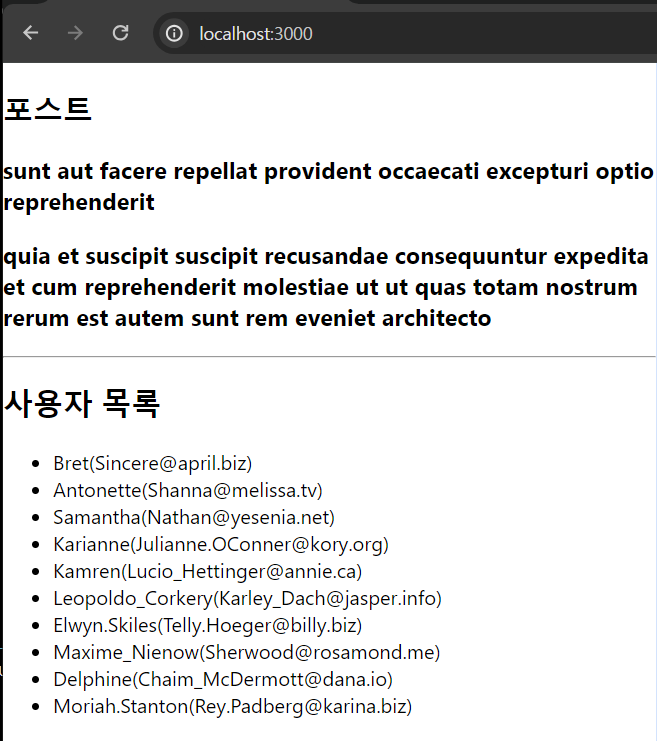

- 리팩토링
    - 반복되는 로직을 따로 분리하여 코드의 양을 줄이기
        ```js
        export default function createRequestThunk(type, request) {
            // 성공 및 실패 액션 타입 정의
            const SUCCESS = `${type}_SUCCESS`;
            const FAILURE = `${type}_FAILURE`;
            return (params) => async (dispatch) => {
                // 시작
                dispatch({ type }); 
                try {
                    const response = await request(params);
                    dispatch({
                        type: SUCCESS,
                        payload: response.data,
                    }); // 성공
                } catch (e) {
                    dispatch({
                        type: FAILURE,
                        payload: e,
                        error: true,
                    }); // 에러 발생
                    throw e;
                }
            };
        }
        
        // 사용법: createRequestThunk('GET_USERS', api.getUSERS);
        ```
    - 위 유틸 함수는 API 요청을 해 주는 thunk 함수를 한 줄로 생성할 수 있게 함
        ```js
        (...)
        import createRequestThunk from "../lib/createRequestThunk";
        (...)
        export const getPost = createRequestThunk(GET_POST, api.getPost);
        export const getUsers = createRequestThunk(GET_USERS, api.getUsers);
        (...)
        ```
    - 로딩 상태만 관리하는 리덕스 모듈을 생성하여 처리
        ```js
        import { createAction, handleActions } from "redux-actions";

        const START_LOADING = "loading/START_LOADING";
        const FINISH_LOADING = "loading/FINISH_LOADING";

        // 요청을 위한 액션 타입을 payload로 설정(ex. "sample/GET_POST")

        export const startLoading = createAction(
            START_LOADING,
            (requestType) => requestType
        );

        export const finishLoading = createAction(
            FINISH_LOADING,
            (requestType) => requestType
        );

        const initialState = {};

        const loading = handleActions(
            {
                [START_LOADING]: (state, action) => ({
                    ...state,
                    [action.payload]: true,
                }),
                [FINISH_LOADING]: (state, action) => ({
                    ...state,
                    [action.payload]: false,
                }),
            },
            initialState
        );

        export default loading;
        ```
    - 요청이 시작될 때 디스패치할 액션
        ```js
        {
            type: 'loading/START_LOADING',
            payload: 'sample/GET_POST'
        }
        ``` 
        - sample/GET_POST의 loading 리듀서 값을 true로 변경
    - 요청이 끝났을 때 디스패치할 액션
        ```js
        {
            type: 'loading/FINISH_LOADING',
            payload: 'sample/GET_POST'
        }
        ```
        - sample/GET_POST의 loading 리듀서 값을 false로 변경
    - 생성한 리듀서 루트 리듀서에 포함
        ```js
        import { combineReducers } from "redux";
        import counter from "./counter";
        import sample from "./sample";
        import loading from "./loading";

        const rootReducer = combineReducers({
            counter,
            sample,
            loading,
        });

        export default rootReducer;
        ```
    - loading 리덕스 모듈 사용
        ```js
        import { startLoading, finishLoading } from "../modules/loading";

        export default function createRequestThunk(type, request) {
            // 성공 및 실패 액션 타입을 정의합니다.
            const SUCCESS = `${type}_SUCCESS`;
            const FAILURE = `${type}_FAILURE`;
            return (params) => async (dispatch) => {
                dispatch({ type }); // 시작됨
                dispatch(startLoading(type));
                try {
                    const response = await request(params);
                    dispatch({
                        type: SUCCESS,
                        payload: response.data,
                    }); // 성공
                    dispatch(finishLoading(type));
                } catch (e) {
                    dispatch({
                        type: FAILURE,
                        payload: e,
                        error: true,
                    }); // 에러 발생
                    dispatch(startLoading(type));
                    throw e;
                }
            };
        }

        // 사용법: createRequestThunk('GET_USERS', api.getUSERS);
        ```
    - 로딩 상태 조회
        ```js
        (...)
        export default connect(
            ({ sample, loading }) => ({
                post: sample.post,
                users: sample.users,
                // loadingPost: sample.loading.GET_POST,
                // loadingUsers: sample.loading.GET_USERS,
                loadingPost: loading["sample/GET_POST"],
                loadingUsers: loading["sample/GET_USERS"],
            }),
            {
                getPost,
                getUsers,
            }
        )(SampleContainer);
        ```
    - sample 리듀서에서 불필요한 코드 제거
        ```js
        import { handleActions } from "redux-actions";
        import * as api from "../lib/api";
        import createRequestThunk from "../lib/createRequestThunk";

        // 액션 타입을 선언
        const GET_POST = "sample/GET_POST";
        const GET_POST_SUCCESS = "sample/GET_POST_SUCCESS";

        const GET_USERS = "sample/GET_USERS";
        const GET_USERS_SUCCESS = "sample/GET_USERS_SUCCESS";

        // thunk 함수를 생성
        // thunk 함수 내부에서는 시작할 때, 성공했을 때, 실패했을 때 다른 액션을 디스패치

        export const getPost = createRequestThunk(GET_POST, api.getPost);
        export const getUsers = createRequestThunk(GET_USERS, api.getUsers);

        // 초기 상태를 선언
        // 요청의 로딩 중 상태는 loading이라는 객체에서 관리
        const initialState = {
            post: null,
            users: null,
        };

        const sample = handleActions(
            {
                [GET_POST_SUCCESS]: (state, action) => ({
                    ...state,
                    post: action.payload,
                }),
                [GET_USERS_SUCCESS]: (state, action) => ({
                    ...state,
                    users: action.payload,
                }),
            },
            initialState
        );

        export default sample;
        ```
        - sample 리듀서에서 로딩 중에 대한 상태를 관리할 필요가 없다.
        - 실패했을 때의 케이스를 관리하고 싶다면, _FAILURE가 붙은 액션을 리듀서에서 처리하거나, 컨테이너 컴포넌트에서 try/catch문을 사용해 에러 값을 조회할 수 있다.

### 2. redux-saga
- yarn add redux-saga
- redux-saga를 사용하는 것이 유리한 경우
    - 기존 요청을 취소 처리해야 할 때(불필요한 중복 요청 방지)
    - 특정 액션이 발생했을 때 다른 액션을 발생시키거나, API 요청 등 리덕스와 관계없는 코드를 실행할 때
    - 웹소켓을 사용할 때, API 요청 실패 시 재요청해야 할 때

1. 제너레이터 함수 이해
    - 하나의 함수에서 값을 여러 개 반환하는 것은 불가능
    - 하지만 제너레이터 함수를 사용하면 값을 순차적으로 여러 개 반환할 수 있다
    - 재너레이터 함수는 function* 키워드를 사용한다
- redux-saga는 재너레이터 함수 문법을 기반으로 비동기 작업을 관리

2. 비동기 카운터 만들기
- counter 리덕스 모듈 수정
- 재너레이터 함수를 사가(saga)라고 함
    ```js
    import { createAction, handleActions } from "redux-actions";
    import { delay, put, takeEvery, takeLatest } from "redux-saga/effects";

    // 액션타입 정의
    const INCREASE = "counter/INCREASE";
    const DECREASE = "counter/DECREASE";
    const INCREASE_ASYNC = "counter/INCREASE_ASYNC";
    const DECREASE_ASYNC = "counter/DECREASE_ASYNC";

    // 액션 생성 함수
    export const increase = createAction(INCREASE);
    export const decrease = createAction(DECREASE);

    // 마우스 클릭 이벤트가 payload 안에 들어가지 않도록
    // () => undefined를 두 번째 파라미터로 넣어 줍니다.
    export const increaseAsync = createAction(INCREASE_ASYNC, () => undefined);
    export const decreaseAsync = createAction(DECREASE_ASYNC, () => undefined);

    function* increaseSaga() {
        yield delay(1000); // 1초를 기다림
        yield put(increase()); // 특정 액션을 디스패치
    }
    
    function* decreaseSaga() {
        yield delay(1000); // 1초를 기다림
        yield put(decrease()); // 특정 액션을 디스패치
    }
    
    export function* counterSaga() {
        // takeEvery는 들어오는 모든 액션에 대해 특정 작업을 처리=
        yield takeEvery(INCREASE_ASYNC, increaseSaga);
        // takeLatest는 기존에 진행 중이던 작업이 있다면 취소 처리하고
        // 가장 마지막으로 실행된 작업만 수행
        yield takeLatest(DECREASE_ASYNC, decreaseSaga);
    }


    // 초기화, 상태는 꼭 객체일 필요가 없다. 숫자도 작동한다.
    const initialState = 0; 

    // 리듀서 생성, 리듀서는 변화를 일으키는 함수
    const counter = handleActions(
        {
            [INCREASE]: (state) => state + 1,
            [DECREASE]: (state) => state - 1,
        },
        initialState
    );

    export default counter;
    ```
- 루트 사가 추가
    ```js
    import { combineReducers } from "redux";
    import { all } from 'redux-saga/effects'
    import counter, { counterSaga } from "./counter";
    import sample from "./sample";
    import loading from "./loading";

    const rootReducer = combineReducers({
        counter,
        sample,
        loading,
    });

    export function* rootSaga() {
        // all 함수는 여러 사가를 합쳐 주는 역할을 합니다.
        yield all([counterSaga()]);
    }

    export default rootReducer;
    ```
- 스토어에 redux-saga 미들웨어 적용
    ```js
    import React from "react";
    import ReactDOM from "react-dom";
    import "./index.css";
    import App from "./App";
    import { createStore, applyMiddleware } from "redux";
    import rootReducer, { rootSaga } from "./modules";
    import { Provider } from "react-redux";
    import { createLogger } from 'redux-logger'
    import { thunk } from 'redux-thunk'
    import createSagaMiddleware from 'redux-saga'


    const logger = createLogger()
    const sagaMiddleware = createSagaMiddleware()
    //스토어 생성
    const store = createStore(rootReducer, applyMiddleware(logger, thunk, sagaMiddleware));
    sagaMiddleware.run(rootSaga)

    const root = ReactDOM.createRoot(document.getElementById('root'));
    root.render(
    //리덕스 적용
    <Provider store={store}>
        <App />
    </Provider>,
    );
    ```
- app 컴포넌트에 렌더링
    ```js
    import CounterContainer from './containers/CounterContainer'

    const App = () => {
    return (
        <div>
        <CounterContainer />
        </div>
    );
    };

    export default App;
    ```
- 리덕스 개발자 도구를 적용
    ```js
    (...)
    import { composeWithDevTools } from '@redux-devtools/extension'

    const logger = createLogger()
    const sagaMiddleware = createSagaMiddleware()
    //스토어 생성
    const store = createStore(rootReducer, composeWithDevTools(applyMiddleware(logger, thunk, sagaMiddleware)));
    (...)
    ```
    - +1 버튼을 누르면 INCREASE_ASYNC와 INCREASE 액션이 두 번 디스패치 된다. takeEvery를 사용하여 increaseSaga를 등록했기 때문
    - -1 버튼을 누르면 DECREASE_ASYNC가 두 번 디스패치 되지만 DECREASE는 한 번 디스패치 된다. takeLatest를 사용하여 decreaseSaga를 등록했기 때문(여러 액션이 중첩되어 디스패치 되었을 때 마지막 액션만 제대로 처리)

3. API 요청 상태 관리하기
- sample 리덕스 모듈 수정
    ```js
    import { createAction, handleActions } from "redux-actions";
    import { call, put, takeLatest } from "redux-saga/effects";
    import * as api from "../lib/api";
    import { startLoading, finishLoading } from "./loading";

    // 액션 타입을 선언
    const GET_POST = "sample/GET_POST";
    const GET_POST_SUCCESS = "sample/GET_POST_SUCCESS";
    const GET_POST_FAILURE = "sample/GET_POST_FAILURE";

    const GET_USERS = "sample/GET_USERS";
    const GET_USERS_SUCCESS = "sample/GET_USERS_SUCCESS";
    const GET_USERS_FAILURE = "sample/GET_USERS_FAILURE"; 

    export const getPost = createAction(GET_POST, (id) => id);
    export const getUsers = createAction(GET_USERS);

    function* getPostSaga(action) {
        yield put(startLoading(GET_POST)); // 로딩 시작
        // 파라미터로 action을 받아 오면 액션의 정보를 조회할 수 있습니다.
        try {
            // call을 사용하면 Promise를 반환하는 함수를 호출하고, 기다릴 수 있습니다.
            // 첫 번째 파라미터는 함수, 나머지 파라미터는 해당 함수에 넣을 인수입니다.
            const post = yield call(api.getPost, action.payload); // api.getPost(action.payload)를 의미
            yield put({
                type: GET_POST_SUCCESS,
                payload: post.data,
            });
    } catch (e) {
            // try/catch 문을 사용하여 에러도 잡을 수 있습니다.
            yield put({
                type: GET_POST_FAILURE,
                payload: e,
                error: true,
            });
        }
        yield put(finishLoading(GET_POST)); // 로딩 완료
    }

    function* getUsersSaga() {
        yield put(startLoading(GET_USERS));
        try {
            const users = yield call(api.getUsers);
            yield put({
                type: GET_USERS_SUCCESS,
                payload: users.data,
            });
        } catch (e) {
            yield put({
                type: GET_USERS_FAILURE,
                payload: e,
                error: true,
            });
        }
        yield put(finishLoading(GET_USERS));
    }

    export function* sampleSaga() {
        yield takeLatest(GET_POST, getPostSaga);
        yield takeLatest(GET_USERS, getUsersSaga);
    }

    // 초기 상태를 선언
    // 요청의 로딩 중 상태는 loading이라는 객체에서 관리
    const initialState = {
        post: null,
        users: null,
    };

    const sample = handleActions(
        {
            [GET_POST_SUCCESS]: (state, action) => ({
                ...state,
                post: action.payload,
            }),
            [GET_USERS_SUCCESS]: (state, action) => ({
                ...state,
                users: action.payload,
            }),
        },
        initialState
    );

    export default sample;
    ```
    - API를 호출해야 하는 상황에는 사가 내부에서 직접 호출하지 않고, call 함수를 사용
    - call 함수의 첫 번째 인수로 호출하고 싶은 함수를, 뒤에 오는 인수들은 해당 함수에 넣어 주고 싶은 인수를 적음
- 루트 사가에 등록
    ```js
    import { combineReducers } from "redux";
    import { all } from "redux-saga/effects";
    import counter, { counterSaga } from "./counter";
    import sample, { sampleSaga } from "./sample";
    import loading from "./loading";

    const rootReducer = combineReducers({
        counter,
        sample,
        loading,
    });

    export function* rootSaga() {
        // all 함수는 여러 사가를 합쳐 주는 역할을 합니다.
        yield all([counterSaga(), sampleSaga()]);
    }

    export default rootReducer;
    ```
- App.js 렌더링
    ```js
    import SampleContainer from "./containers/SampleContainer";

    const App = () => {
    return (
        <div>
        <SampleContainer />
        </div>
    );
    };

    export default App;
    ```

    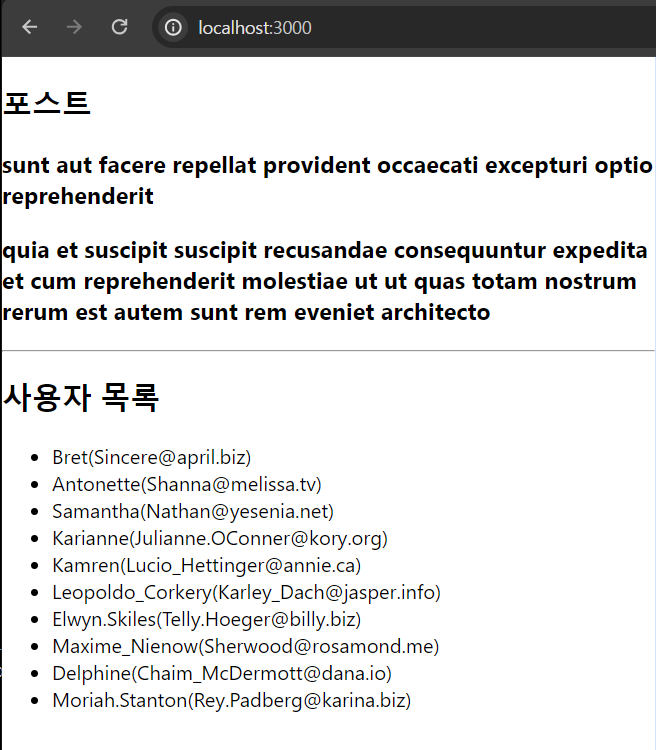

    - 정상 작동

- 리팩토링
    ```js
    import { call, put } from "redux-saga/effects";
    import { startLoading, finishLoading } from "../modules/loading";

    export default function createRequestSaga(type, request) {
        const SUCCESS = `${type}_SUCCESS`;
        const FAILURE = `${type}_FAILURE`;

        return function* (action) {
            yield put(startLoading(type)); // 로딩 시작
            try {
                const response = yield call(request, action.payload);
                yield put({
                    type: SUCCESS,
                    payload: response.data,
                });
            } catch (e) {
                yield put({
                    type: FAILURE,
                    payload: e,
                    error: true,
                });
            }
            yield put(finishLoading(type)); // 로딩 끝
        };
    }
    ```
- 리팩토링 적용
    ```js
    import { createAction, handleActions } from "redux-actions";
    import {  takeLatest } from "redux-saga/effects";
    import * as api from "../lib/api";
    import createRequestSaga from "../lib/createRequestSaga";

    // 액션 타입을 선언
    const GET_POST = "sample/GET_POST";
    const GET_POST_SUCCESS = "sample/GET_POST_SUCCESS";

    const GET_USERS = "sample/GET_USERS";
    const GET_USERS_SUCCESS = "sample/GET_USERS_SUCCESS";

    export const getPost = createAction(GET_POST, (id) => id);
    export const getUsers = createAction(GET_USERS);

    const getPostSaga = createRequestSaga(GET_POST, api.getPost);
    const getUsersSaga = createRequestSaga(GET_USERS, api.getUsers);

    export function* sampleSaga() {
        yield takeLatest(GET_POST, getPostSaga)
        yield takeLatest(GET_POST, getUsersSaga)

    }

    // 초기 상태를 선언
    // 요청의 로딩 중 상태는 loading이라는 객체에서 관리
    const initialState = {
        post: null,
        users: null,
    };

    const sample = handleActions(
        {
            [GET_POST_SUCCESS]: (state, action) => ({
                ...state,
                post: action.payload,
            }),
            [GET_USERS_SUCCESS]: (state, action) => ({
                ...state,
                users: action.payload,
            }),
        },
        initialState
    );

    export default sample;
    ```
5. 알아 두면 유용한 기능
- 사가 내부에서 현재 상태 조회하는 방법
- counter.js
```js
import { delay, put, takeEvery, takeLatest, select } from "redux-saga/effects";
(...)

function* increaseSaga() {
  yield delay(1000); // 1초를 기다립니다.
  yield put(increase()); // 특정 액션을 디스패치합니다.
  const number = yield select((state) => state.counter); // state는 스토어 상태를 의미함
  console.log(`현재 값은 ${number}입니다.`);
}
```
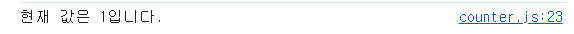

- 사가가 실행되는 주기를 제한하는 방법
    - takeEvery 대신 throttle 함수 사용하기 > n초에 단 한 번만 호출될 수 있도록 설정할 수 있다
    - ex) yeid throttle(3000, INCREASE_ASYNC, increaseSaga);

- redux-saga 메뉴얼
    - https://redux-saga.js.org/

## 18.4 정리
- 리덕스 미들웨어를 사용하는 방법을 알아보고, 비동기 작업을 미들웨어로 어떻게 처리할 수 있는지 학습
- redux-thunk는 일반 함수로 이루어져 있어 간단명료
- redux-saga는 복잡한 상황에서 효율적으로 작업을 관리
    - 재너레이터 함수를 기반으로 비동기 작업을 관리
- 미들웨어를 사용하지 않고 컴포넌트단에서 API를 요청하는 것도 틀린 방법이 아니다
- 미들웨어 : 액션을 디스패치했을 때 리듀서에서 이를 처리하기에 앞서 사전에 지정된 작업들을 실행 할 수 있게끔 하는 기능
